## Setup

In [1]:
import os
import optuna
from dotenv import load_dotenv
from sklearn.metrics import recall_score

from src.py_src import util
from src.py_src.models import GatekeeperModel

C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
load_dotenv()

True

In [3]:
slided_df_path = os.path.join(os.getenv("SLIDED_DFS_CSV_PATH"), "data_slided_V4.parquet")
target_class = 'target_class_in_6h'
target_flux = 'target_flux_in_6h'
target_columns = [target_class, target_flux]

df_model_input = util.create_df_model_input_opt(slided_df_path, target_columns, "xl_")

Carregando 46 colunas do arquivo Parquet...


## Preparing Data

In [4]:
gatekeeper_pool = df_model_input.copy()

train_pct = 0.7
val_pct = (1-train_pct)/2

data = util.prepare_data(
    df_model_input=gatekeeper_pool,
    target_class_col=target_class,
    lambda_function=lambda lb: 1 if lb >= 1 else 0,
    train_pct=train_pct,
    val_pct=val_pct,
    target_flux_col=target_flux
)

## Discovery Model

In [5]:
discovery_model = GatekeeperModel(
    params={
        'n_estimators': 300,
        'learning_rate': 0.05,
        'max_depth': 5,
        'n_jobs': -1,
        'random_state': 42
    }
)

In [6]:
selected_features = discovery_model.discover_top_features(
    x=data['x']['train'],
    y=data['y']['train'],
    flux_values=data['flux']['train'],
    cumulative_threshold=0.95
)

--- Quick Scan (Discovery Mode) ---
Quick Scan concluído. 23 features selecionadas (de 44).


## Hyperparameter Tuning (Optuna)


In [7]:
def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'logloss',
        'n_estimators': 1000,
        'random_state': 1502,
        'n_jobs': -1,
        'early_stopping_rounds': 50,
        'device': 'cuda',

        'scale_pos_weight': trial.suggest_float("scale_pos_weight", 1.0, 5.0),
        'max_depth': trial.suggest_int('max_depth', 3, 8),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'subsample': trial.suggest_float('subsample', 0.6, 0.9),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 0.9),
        'gamma': trial.suggest_float('gamma', 0.1, 5.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10)
    }

    model = GatekeeperModel(params=params, features_to_keep=selected_features)

    model.fit(
        x=data['x']['train'],
        y=data['y']['train'],
        eval_set=[(data['x']['val'], data['y']['val'])],
        verbose=False
    )

    y_pred_proba = model.predict_proba(data['x']['val'])[:, 1]
    y_pred_class = (y_pred_proba >= 0.5).astype(int)

    recall_flare = recall_score(data['y']['val'], y_pred_class, pos_label=1)
    recall_no_flare = recall_score(data['y']['val'], y_pred_class, pos_label=0)
    w = 2
    score = (w * recall_flare) + (1 * recall_no_flare)

    return score

In [8]:
study = optuna.create_study(direction='maximize')
print("\nIniciando tuning...")
study.optimize(objective, n_trials=50)

print(f"\nBest Score: {study.best_value:.4f}")
best_params = study.best_params

best_params.update({
    'n_estimators': 1000, 'objective': 'binary:logistic',
    'eval_metric': 'logloss', 'random_state': 1502,
    'n_jobs': -1, 'early_stopping_rounds': 50
})

[I 2025-12-16 20:20:44,913] A new study created in memory with name: no-name-911f822a-6f7c-4bc2-b45c-b10ca87b6082



Iniciando tuning...


C:\Users\Eduardo\BES\IC\Solar_Flares\.venv\Lib\site-packages\xgboost\core.py:774: UserWarning: [20:20:47] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\common\error_msg.cc:62: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  return func(**kwargs)
[I 2025-12-16 20:20:47,914] Trial 0 finished with value: 2.342154624509951 and parameters: {'scale_pos_weight': 1.9684902060009892, 'max_depth': 7, 'learning_rate': 0.08856683582387671, 'subsample': 0.7325483712970577, 'colsample_bytree': 0.6762661923073197, 'gamma': 4.88856993951612, 'min_child_weight': 5}. Best is trial 0 with value: 2.342154624509951.
[I 2025-12-16 20:20:49,604] Trial 1 finished wit


Best Score: 2.3989


In [9]:
final_model = GatekeeperModel(params=study.best_params, features_to_keep=selected_features)
final_model.fit(
    x=data['x']['train'], y=data['y']['train']
)

,params,"{'colsample_bytree': 0.6461896716881914, 'gamma': 1.0291972360025121, 'learning_rate': 0.0701214286635538, 'max_depth': 3, ...}"
,threshold,0.5
,features_to_keep,"['xl_max_1h', 'xl_mean_6h', ...]"


## Threshold Tuning

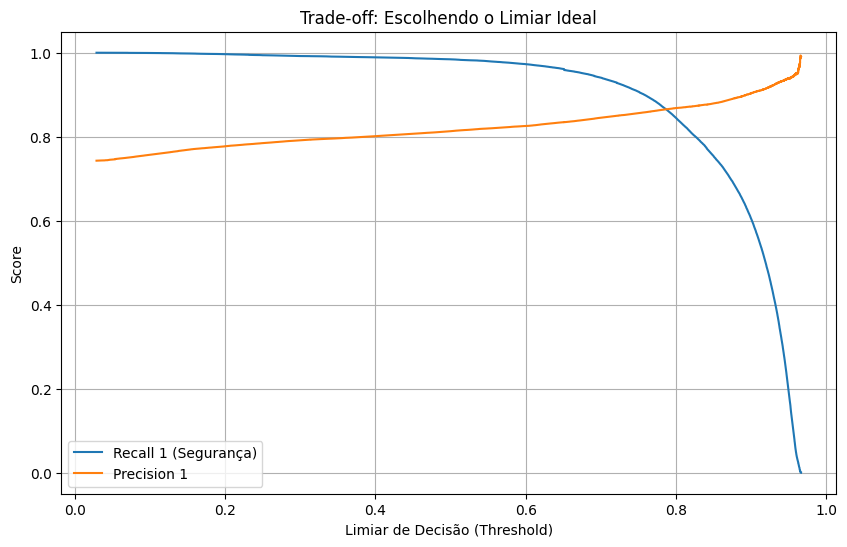

In [10]:
fig = final_model.get_threshold_graph(data['x']['test'], data['y']['test'])
display(fig)

In [11]:
final_model.optimize_threshold(data['x']['test'], data['y']['test'])

Threshold de Equilíbrio (P=R): 0.7871


np.float32(0.78706026)

## Results

In [12]:
print(final_model.get_classification_report(
    data['x']['test'], data['y']['test'], target_names=['No Flare', 'Flare']
))

              precision    recall  f1-score   support

    No Flare       0.61      0.61      0.61     58764
       Flare       0.87      0.87      0.87    169980

    accuracy                           0.80    228744
   macro avg       0.74      0.74      0.74    228744
weighted avg       0.80      0.80      0.80    228744



In [13]:
fig, summary = final_model.analyze_flux_errors(
    data['x']['test'], data['y']['test'],
    flux_values=data['flux']['test']
)
display(summary)

Outcome,TN (Correct Rejection),FP (False Alarm),FP Rate (%),TP (Hit),FN (Miss),FN Rate (%)
Zone,,,,,,
0. Global Range (No Buffer),35886,22878,38.9,147101,22879,13.5


In [14]:
error_report = final_model.analyze_error_distribution(
    x=data['x']['test'],
    y_true=data['y']['test'],
    flux_values=data['flux']['test']
)
display(error_report)

,FN (Miss),FP (False Alarm),FN (Miss) Avg Flux,FP (False Alarm) Avg Flux
SolarClass,,,,
A (< B1.0),216,22878,4.27e-08,-
B (1.0 - 9.9),17754,0,3.42e-07,-
C (1.0 - 9.9),4585,0,2.52e-06,-
M (1.0 - 9.9),312,0,2.27e-05,-
X (> M10),12,0,2.90e-04,-


## Features Importance

In [15]:
features_importance = final_model.get_feature_importance()
features_importance

,feature,importance,cumulative_importance
1,xl_mean_6h,0.340637,0.340637
0,xl_max_1h,0.310145,0.650782
2,xl_max_6h,0.096098,0.746880
3,xl_mean_12h,0.054350,0.801230
5,xl_max_12h,0.050953,0.852183
4,xl_std_1h,0.023455,0.875638
7,xl_log_mean_6h,0.021222,0.896860
9,xl_std_6h,0.019352,0.916213
11,xl_log_mean_12h,0.012923,0.929135
8,xl_max_24h,0.010780,0.939915


## Export

In [16]:
gatekeeper_dir = os.getenv('GATEKEEPER_MODELS_PATH')
save_path = os.path.join(gatekeeper_dir, '6h/gatekeeper_6h_v1.joblib')
final_model.save(save_path)

Modelo salvo em: C:\Users\Eduardo\BES\IC\Solar_Flares\src\notebooks\models\gatekeeper\6h/gatekeeper_6h_v1.joblib
